# Sentiment Analysis on movie reviews

Hi 🙂, if you are seeing this notebook, you have succesfully started your first project on FloydHub 🚀, hooray!!

![sentiment](images/sentiment.png)

In this notebook we will build a classifier to predict the sentiment of movie reviewes. This type of task is really common for deriving usefull insight about the reputation of the product or the service managed by the company.

### Resource

The dataset was taken from [Stanford Large Movie Reviews](http://ai.stanford.edu/~amaas/data/sentiment/).

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification** task consists of predicting the polarity (positive or negative) of a given text.

**Note**

For executing a Code Cell, click on the Cell and run `Shift + Enter` (shortcut for Run).

## Initial Setup

Let's start by importing the packages, Setting the training variables and loading the csv file from which get all the data we need.

In [1]:
! pip -q install seaborn h5py==2.8.0rc1

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import string

# For reproducibility
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

Using TensorFlow backend.


## Configuration

In [3]:
# Set training given hardware
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 128
    EPOCHS = 2
    VOCAB_SIZE = 30000
    MAX_LEN = 500
    EMBEDDING = 40
    
else:
    # CPU
    BATCH_SIZE = 32
    EPOCHS = 2
    VOCAB_SIZE = 20000
    MAX_LEN = 90
    EMBEDDING = 40

## Data

Let's take a look at data. The plot 'Tokens per sentence' is useful for setting the MAX_LEN variable, since we are building a static computational graph, we need to know the max lenght before starting the computation.

The labels are encoded in the dataset: **0** is for *negative* and **1** for a *positive* review.

train shape (rows, columns):  (25000, 2) , validation shape (rows, columns):  (25000, 2)

--- First Sample ---
Label: 0
Text: Watch the Original with the same title from 1944! This made for TV movie, is just god-awful! Although it does use (as far as I can tell) almost the same dialog, it just doesn't work! Is it the acting, the poor directing? OK so it's made for TV, but why watch a bad copy, when you can get your hands on the superb original? Especially as you'll be spoiled to the plot and won't enjoy the original as much, as if you've watched it first! <br /><br />There are a few things that are different from the original (it's shorter for once), but all are for the worse! The actors playing the parts here, just don't fit the bill! You just don't believe them and who could top Edward G. Robinsons performance from the original? If you want, only watch it after you've seen the original and even then you'll be very brave, if you watch it through! It's almost sacrilege!


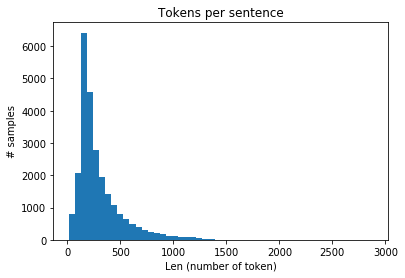

In [4]:
DS_PATH = '/floyd/data/imdb/' # ADD path/to/dataset
LABELS = ['negative', 'positive']

# Load data
train = pd.read_csv(os.path.join(DS_PATH,"train.tsv"), sep='\t')  # EDIT WITH YOUR TRAIN FILE NAME
val = pd.read_csv(os.path.join(DS_PATH,"val.tsv"), sep='\t')  # EDIT WITH YOUR VALIDATION FILE NAME

print("train shape (rows, columns): ", train.shape, ", validation shape (rows, columns): ",  val.shape)

# How a row/sample looks like
print("\n--- First Sample ---")
print('Label:', train['label'][0])
print('Text:', train['text'][0])

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in train['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Data Preprocessing

Before feeding the data into the model, we have to preprocess the sentences according to the model and type of computation we want to perform. In this Code Cell we will convert the Token to index(this representation will save a lot of memory) and pad the sentence at the same lenght. If a sentence has a number of tokens less than MAX_LEN will be trimmed.

In [5]:
imdb_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
imdb_tokenizer.fit_on_texts(train['text'].values)

x_train_seq = imdb_tokenizer.texts_to_sequences(train['text'].values)
x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train, y_val = train['label'].values, val['label'].values

print('First sample before preprocessing: \n', train['text'].values[0], '\n')
print('First sample after preprocessing: \n', x_train[0])

First sample before preprocessing: 
 Watch the Original with the same title from 1944! This made for TV movie, is just god-awful! Although it does use (as far as I can tell) almost the same dialog, it just doesn't work! Is it the acting, the poor directing? OK so it's made for TV, but why watch a bad copy, when you can get your hands on the superb original? Especially as you'll be spoiled to the plot and won't enjoy the original as much, as if you've watched it first! <br /><br />There are a few things that are different from the original (it's shorter for once), but all are for the worse! The actors playing the parts here, just don't fit the bill! You just don't believe them and who could top Edward G. Robinsons performance from the original? If you want, only watch it after you've seen the original and even then you'll be very brave, if you watch it through! It's almost sacrilege! 

First sample after preprocessing: 
 [   5    1  111    2  525  354    1  201   14   73   14   44  871 

## Model

We will implement a model similar to Kim Yoon’s [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882). We took the model from the [Keras repository](https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py). 

![cnn for text](images/cnn.png)
*Image from [the paper]((https://arxiv.org/abs/1408.5882)*

In [6]:
# Model Parameters - You can play with these

FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250

In [7]:
# CNN Model
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(VOCAB_SIZE, EMBEDDING, input_length=MAX_LEN))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 40)            800000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 40)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 250)           30250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
____________________________________________

## Train & Evaluate

The Training is defined at the beginning by the type of instance on which runs:

- On a CPU instance it will train for 2 epoch in about 2 minutes.

- On a GPU instance it will train for 2 epoch in about 1 minutes.

The model will start overfitting after 2/3 epochs. You should get an accuracy of > 84%.

In [8]:
# fit a model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1)

# Evaluate the model
score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print('Accuracy: ', acc*100)

pred = model.predict_classes(x_val)

Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22500/22500 [==============================] - 54s 2ms/step - loss: 0.4796 - acc: 0.7458 - val_loss: 0.3631 - val_acc: 0.8392
Epoch 2/2
25000/25000 [==============================] - 5s 202us/step
Accuracy:  85.328


             precision    recall  f1-score   support

   negative       0.82      0.88      0.85     11704
   positive       0.89      0.83      0.86     13296

avg / total       0.86      0.85      0.85     25000



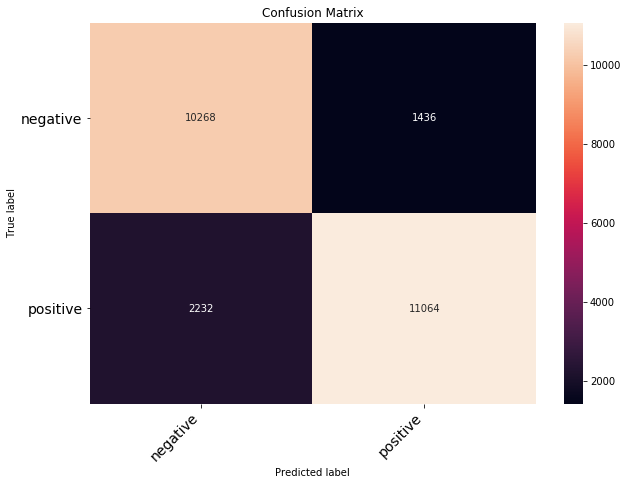

In [9]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix
cnf_matrix = confusion_matrix(pred, y_val)
_ = print_confusion_matrix(cnf_matrix, LABELS)

# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(pred, y_val, target_names=LABELS)
print(report)

## It's your turn

We have prepared some custom reviews for testing. Edit the review variable and Run the code Cell below, have fun :)

- Review: "Star Wars episode 8 is the best movie I ever seen. Fan Service, Rebel vs Empire, Jedi battles, Luke! AWESOME."
- Review: "A completely waste of my time."
- Review: "Worst movie ever seen."
- Review: "Go to the cinema, now! You cannot miss this masterpiece."

In [10]:
def get_prediction(review):
    # Preprocessing
    review_np_array = imdb_tokenizer.texts_to_sequences([review])
    review_np_array = sequence.pad_sequences(review_np_array, maxlen=MAX_LEN, padding="post", value=0)
    # Prediction
    prediction = LABELS[model.predict_classes(review_np_array)[0][0]]
    print('REVIEW:', review, ' - PREDICTION:', prediction)

review = 'A completely waste of my time.'  # TYPE YOUR REVIEW HERE
get_prediction(review)

REVIEW: A completely waste of my time.  - PREDICTION: negative


## Save the result

In [11]:
import pickle

# Saving Tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(imdb_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Model Weight
model.save_weights('models/cnn_sentiment_weights.h5')